# Playing with detector bands
In this notebook we read in an experiment's yaml file, then create custom bandshapes that we use to explore detector loadings and sensitivities as those band shapes are changed.

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import yaml
import sys
#sys.path.insert(0,'/Users/ruhl/code/jbolo/python/')
from  jbolo_funcs import *

%matplotlib inline
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [8, 10]

First let's create a function that builds a realistic-looking band shape given some input parameters.

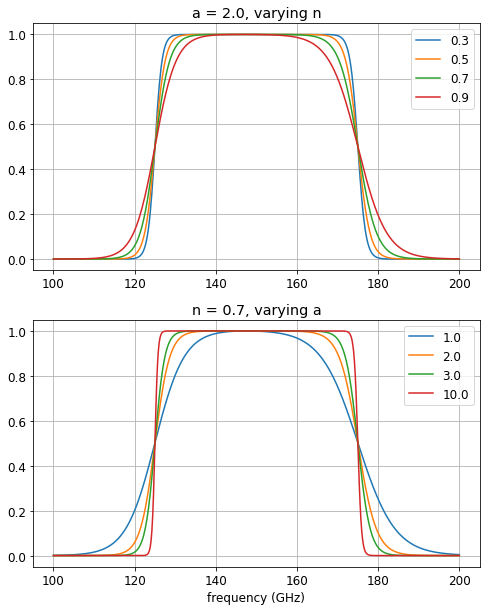

In [2]:
def logistic_bandmodel(nuvec, nu0, dnu,a,n):
    '''Returns a logistic-function band model, 
       peaking at unity, given input central frequency 
       and bandwidth in GHz.
       
       nuvec:  vector of frequencies at which to return the function
       nu0:  center frequency
       dnu:  bandwidth
       a: prefactor used in logistic model
       n: exponent used in logistic model
       
       band = f1*f2, where f1 is a highpass, f2 is a lowpass
       k1 = a*(20/lowedge)**n
       k2 = a*(20/highedge)**m
       f1 =     1/(1+np.exp(-k1*(nu-nu_lowedge )))
       f2 = 1 - 1/(1+np.exp(-k2*(nu-nu_highedge)))
    '''
    nu_lowedge  = nu0-dnu/2
    nu_highedge = nu0+dnu/2
    # I tuned aa and nn by hand to "best fit by eye" (globally) 
    # the bands Sara provided in the first plot below.
    #aa = 2     # smaller aa gives broader tails at all frequency bands
    #nn = 0.7   # larger nn gives broader tails at higher frequency bands
    k1 = a*(20/nu_lowedge)**n
    f1 = 1/(1+np.exp(-k1*(nuvec-nu_lowedge )))
    k2 = a*(20/nu_highedge)**n
    f2 = 1-1/(1+np.exp(-k2*(nuvec-nu_highedge)))
    f = f1*f2
    f = f/np.max(f) # normalize to unity
    return f

nuvec = np.linspace(100,200,500)
plt.clf()
plt.subplot(2,1,1)
for n in [0.3,0.5,0.7,0.9]:
  f = logistic_bandmodel(nuvec,150,50,2.0, n)
  plt.plot(nuvec,f,label=str(n))
plt.legend()
plt.title('a = 2.0, varying n')
plt.grid()

plt.subplot(2,1,2)
for a in [1.0, 2.0, 3.0, 10.0]:
  f = logistic_bandmodel(nuvec,150,50,a, 0.7)
  plt.plot(nuvec,f,label=str(a))
plt.legend()
plt.xlabel('frequency (GHz)')
plt.title('n = 0.7, varying a')
plt.grid()

We'll use n = 0.7, a = 2.0 as our default.  This shows that if we want to compare that with a very square band, we can raise 'a' high and set 'n' low. 

With that function in place, let's use jbolo to calculate P_optical and NET for an array of band centers and widths, for each channel in the yaml file.

In this example we'll pretend that the Psat is being set to 3.0 times the optical power, 
overloading whatever Psat_method is in the yaml file.

In [3]:
!ls yamls

Example_experiment.yaml


In [187]:
##### yamlfile = 'yamls/Example_experiment.yaml'
sim = yaml.safe_load(open(yamlfile))

# Overload whatever is in the yaml file, to set psats based on optical power.
sim['bolo_config']['psat_method'] = 'from_optical_power'
sim['bolo_config']['psat_factor'] = 3.0
    
# You can change the site or pwv if you want 
sim['sources']['atmosphere']['site'] = 'Pole'
sim['sources']['atmosphere']['pwv']  = 350


chlist = list(sim['channels'].keys())

# The bands in the yaml file are flat bands;  let's use the edges to determine
# the default band center and width, and then vary those by +- 10% in band center and width.
# This will create a 2D array of input (center,width) parameters, and we'll calculate
# P_optical and NET for each point in the 2D space.
#
nbins = 20
center_scalefactor = np.linspace(0.9,1.1,nbins)
width_scalefactor = np.linspace(0.8,1.3,nbins)

# set our logistic model parameters
a = 2.0
n = 0.7
#a = 10.0
#n = 0.9
plottitle= sim['sources']['atmosphere']['site']+', pvw='+str(sim['sources']['atmosphere']['pwv'])+',a='+str(a)+', n='+str(n)
print(plottitle)

out_NET = {}
out_Popt = {}
out_center = {}
out_width = {}

for ch in chlist:
    out_NET[ch] = np.empty((nbins,nbins))
    out_Popt[ch]= np.empty((nbins,nbins))
    out_center[ch]= np.empty((nbins,nbins))
    out_width[ch]= np.empty((nbins,nbins))
    
    # Save the low and high edges, and extend frequency coverage for "soft" bands,
    # so that integrals will be done over an extended range.
    sim['channels'][ch]['nu_low_0']  = sim['channels'][ch]['nu_low']
    sim['channels'][ch]['nu_high_0'] = sim['channels'][ch]['nu_high']
    sim['channels'][ch]['nu_center'] = (sim['channels'][ch]['nu_high_0'] + sim['channels'][ch]['nu_low_0'])/2.0
    sim['channels'][ch]['nu_width']  = sim['channels'][ch]['nu_high_0'] - sim['channels'][ch]['nu_low_0']
    sim['channels'][ch]['nu_low'] *= 0.5
    sim['channels'][ch]['nu_high'] *= 2.0
    
cc = 0
for cf in center_scalefactor:
    ww = 0
    for wf in width_scalefactor:
        if 'outputs' in sim.keys():  
            sim['outputs'].clear()  # Clear previous iteration results so things don't multiply.
        for ch in chlist:
            sim['channels'][ch]['band_response']['method']='band_vector'
            sim['channels'][ch]['band_response']['nuband_in'] = np.linspace(sim['channels'][ch]['nu_low'], sim['channels'][ch]['nu_high'], 1000)
            _outwidth  = wf*sim['channels'][ch]['nu_width']
            _outcenter = cf*sim['channels'][ch]['nu_center']
            sim['channels'][ch]['band_response']['band_in'] = logistic_bandmodel(sim['channels'][ch]['band_response']['nuband_in'], _outcenter, _outwidth,a,n)
            out_center[ch][ww][cc] = _outcenter
            out_width[ch][ww][cc]  = _outwidth
            
        # this runs on all channels
        run_optics(sim)
        run_bolos(sim)
        
        for ch in chlist:
            out_NET[ch][ww][cc] = sim['outputs'][ch]['NET_NC_total']
            out_Popt[ch][ww][cc]= sim['outputs'][ch]['P_opt']

        ww += 1
    cc += 1



Pole, pvw=350,a=2.0, n=0.7


Text(0.5, 0.98, 'Pole, pvw=350,a=2.0, n=0.7')

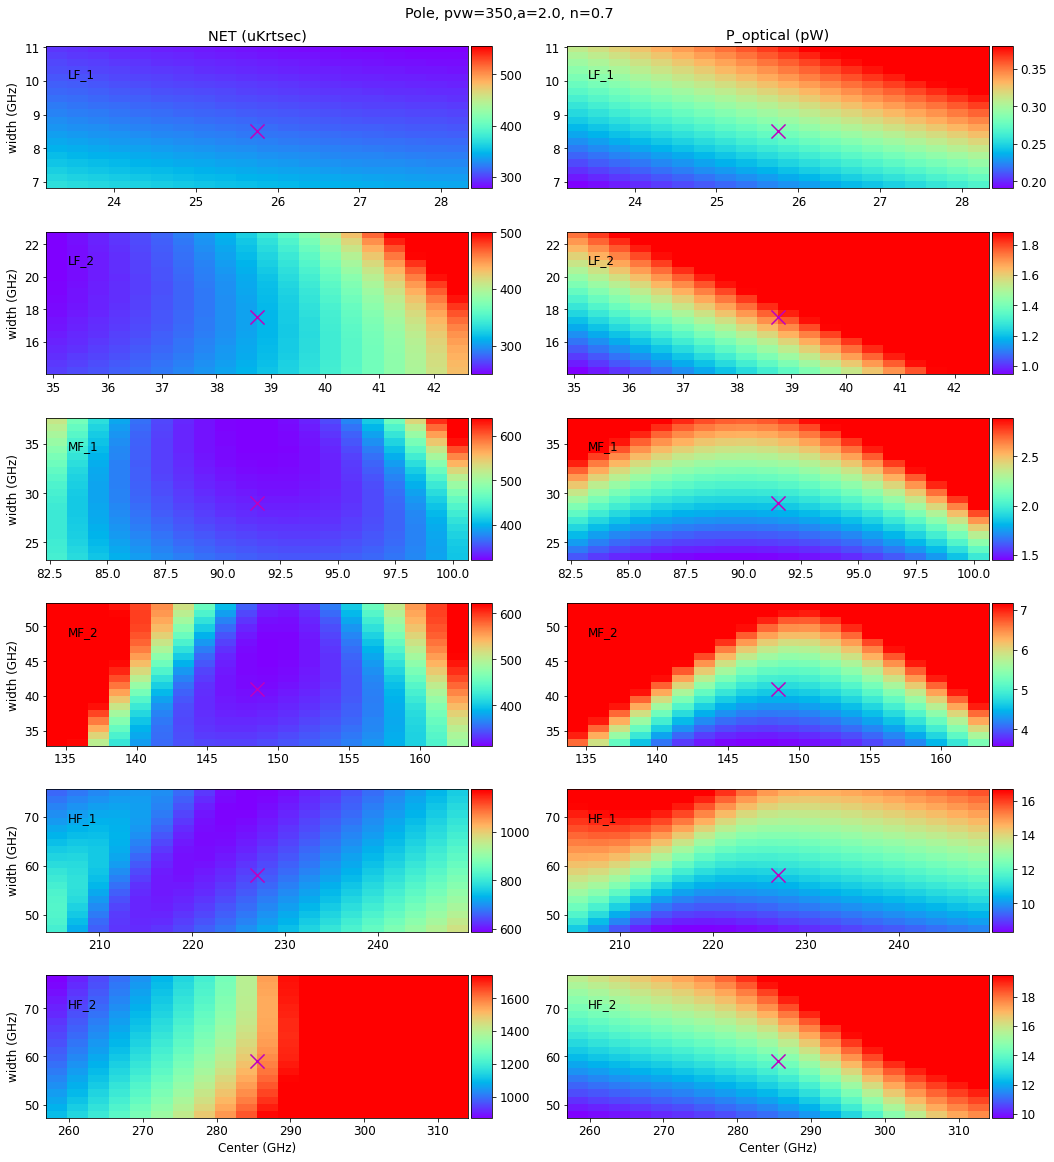

In [188]:
ch = 'MF_2'
plt.rcParams['figure.figsize'] = [14, 16]

def pltnet(ch,rownum,colnum):
    netarr = 1e6*out_NET[ch]
    minval = np.min(netarr)
    maxval = 2*minval
    abc= axs[rownum,colnum].imshow(netarr,vmin = minval, vmax=maxval,cmap='rainbow',origin='lower',aspect='auto',extent=(np.min(out_center[ch]),np.max(out_center[ch]),np.min(out_width[ch]),np.max(out_width[ch])))
    axs[rownum,colnum].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axs[rownum,colnum].transAxes)
    divider = make_axes_locatable(axs[rownum,colnum])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    axs[rownum,colnum].scatter(sim['channels'][ch]['nu_center'],sim['channels'][ch]['nu_width'],s=200,marker='x',c='m')
    fig.colorbar(abc, cax=cax, orientation='vertical')
    
def pltpopt(ch,rownum,colnum):
    poptarr = 1e12*out_Popt[ch]
    minval = np.min(poptarr)
    maxval = 2*minval
    abc= axs[rownum,colnum].imshow(poptarr,vmin = minval, vmax=maxval,cmap='rainbow',origin='lower',aspect='auto',extent=(np.min(out_center[ch]),np.max(out_center[ch]),np.min(out_width[ch]),np.max(out_width[ch])))
    axs[rownum,colnum].text(0.05, 0.8, ch, horizontalalignment='left',verticalalignment='center', transform=axs[rownum,colnum].transAxes)
    divider = make_axes_locatable(axs[rownum,colnum])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    axs[rownum,colnum].scatter(sim['channels'][ch]['nu_center'],sim['channels'][ch]['nu_width'],s=200,marker='x',c='m')
    fig.colorbar(abc, cax=cax, orientation='vertical')
    
npl_x = 2
npl_y = len(chlist)

fig, axs = plt.subplots(nrows=npl_y,ncols=npl_x,constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=2 / 72, h_pad=2 / 72, hspace=0.1,
                                wspace=0.1)
rownum = 0
for ch in chlist:
    colnum = 0
    pltnet(ch,rownum,colnum)
    colnum = 1
    pltpopt(ch,rownum,colnum)
    rownum += 1
    
axs[0,0].set_title('NET (uKrtsec)')
for jj in range(len(chlist)):
    axs[jj,0].set_ylabel('width (GHz)')
axs[0,1].set_title('P_optical (pW)')
axs[npl_y-1,0].set_xlabel('Center (GHz)')
axs[npl_y-1,1].set_xlabel('Center (GHz)')

fig.suptitle(plottitle)
        